In [1]:
import glob
import pandas as pd
import gzip
import networkx as nx
from singlecellmultiomics.utils import hamming_distance
from itertools import product, combinations
from multiprocessing import Pool
import matplotlib.pyplot as plt
import numpy as np

In [2]:


tx_meta = pd.concat([
    pd.read_csv(p, delimiter=',', index_col=0)
    for p in glob.glob(f'../data/meta/day*.csv')
])
tx_meta = tx_meta[~tx_meta.index.duplicated(keep='first')]
tx_meta.sort_index()

orig.ident  nCount_RNA  nFeature_RNA  log1p_nCount_RNA  \
AAACCCAAGAAACACT_d4     rawday4       24558          5644         10.145335   
AAACCCAAGCAACAGC_d0     rawday0        8297          2655          9.034557   
AAACCCAAGCTAGAAT_d7b   rawday7b       12613          4153          9.461410   
AAACCCAAGTCACGAG_d7b   rawday7b       10868          3736          9.311633   
AAACCCAAGTTTGGCT_d4     rawday4       23239          5056         10.088597   
...                         ...         ...           ...               ...   
TTTGTTGTCGCTACGG_d7a   rawday7a       10249          3488          9.254931   
TTTGTTGTCGTTCAGA_d0     rawday0        6623          2440          8.807173   
TTTGTTGTCTACTATC_d7b   rawday7b       11805          3923          9.394244   
TTTGTTGTCTAGTCAG_d7b   rawday7b        7771          3253          8.974745   
TTTGTTGTCTGAGCAT_d4     rawday4       20791          5278          9.977992   

                      log1p_nFeature_RNA  percent.mt  percent.ribo  \
AAACCCAAGAAACACT_d4             8.665613    2.229987     18.114719   
AAACCCAAGCAACAGC_d0             7.893199    1.335400     27.816859   
AAACCCAAGCTAGAAT_d7b            8.346642    3.757878     16.922119   
AAACCCAAGTCACGAG_d7b            8.240649    3.868052     21.861726   
AAACCCAAGTTTGGCT_d4             8.560253    2.497299     23.821990   
...                                  ...         ...           ...   
TTTGTTGTCGCTACGG_d7a            8.174139    2.190340     21.989479   
TTTGTTGTCGTTCAGA_d0             7.804659    1.377039     26.118844   
TTTGTTGTCTACTATC_d7b            8.287025    2.854052     17.274089   
TTTGTTGTCTAGTCAG_d7b            8.098947    3.189873     11.848101   
TTTGTTGTCTGAGCAT_d4             8.595820    2.371670     22.677063   

                      mad5_nFeature_RNA  mad3_nFeature_RNA  mad5_nCount_RNA  \
AAACCCAAGAAACACT_d4                True               True             True   
AAACCCAAGCAACAGC_d0                True               True             True   
AAACCCAAGCTAGAAT_d7b               True               True             True   
AAACCCAAGTCACGAG_d7b               True               True             True   
AAACCCAAGTTTGGCT_d4                True               True             True   
...                                 ...                ...              ...   
TTTGTTGTCGCTACGG_d7a               True               True             True   
TTTGTTGTCGTTCAGA_d0                True               True             True   
TTTGTTGTCTACTATC_d7b               True               True             True   
TTTGTTGTCTAGTCAG_d7b               True               True             True   
TTTGTTGTCTGAGCAT_d4                True               True             True   

                      ...  clustering_sct.1.2  clustering_sct.0.55  \
AAACCCAAGAAACACT_d4   ...                 NaN                  NaN   
AAACCCAAGCAACAGC_d0   ...                 5.0                  2.0   
AAACCCAAGCTAGAAT_d7b  ...                11.0                  8.0   
AAACCCAAGTCACGAG_d7b  ...                 7.0                  7.0   
AAACCCAAGTTTGGCT_d4   ...                 NaN                  NaN   
...                   ...                 ...                  ...   
TTTGTTGTCGCTACGG_d7a  ...                 1.0                  2.0   
TTTGTTGTCGTTCAGA_d0   ...                 2.0                  1.0   
TTTGTTGTCTACTATC_d7b  ...                11.0                  3.0   
TTTGTTGTCTAGTCAG_d7b  ...                 4.0                  5.0   
TTTGTTGTCTGAGCAT_d4   ...                 NaN                  NaN   

                      clustering_sct.0.95  clustering_sct.0.65  \
AAACCCAAGAAACACT_d4                   NaN                  NaN   
AAACCCAAGCAACAGC_d0                   4.0                  2.0   
AAACCCAAGCTAGAAT_d7b                 10.0                  8.0   
AAACCCAAGTCACGAG_d7b                  7.0                  7.0   
AAACCCAAGTTTGGCT_d4                   NaN                  NaN   
...                                   ...    

In [3]:
def get_edit_graph(data):
    edit_graph = nx.Graph()
    
    main_candidates = []
    sequences = []
    min_main_frac = 0.05
    total = sum([d['n'] for d in data])
    max_sequences = 150
    for d in data:
        seq = d['sequence']
        edit_graph.add_node(seq, **d)
        if d['n']/total >= min_main_frac:
            main_candidates.append(seq)
            sequences.append(seq)
        else:
            sequences.append(seq)
        if len(sequences)>=max_sequences: # Stop adding more sequences to the graph
            break
    
    for a,b in product(main_candidates, sequences):
        if a==b:
            continue 
        dist = hamming_distance(a,b)
        if dist<=2:
            edit_graph.add_edge(a,b, weight=1)
    return edit_graph


def get_graph_features(data):
    edit_graph = get_edit_graph(data)
    connected_components = {}
    MAX_COMP = 3
    
    for i, component in enumerate(nx.connected_components( edit_graph )):
        
        counts = [edit_graph.nodes[node]['n'] for node in component]
        connected_components[i] = { 'total_n': sum(counts), 'cardinality':len(counts) }
    
    graph_meta_frame = pd.DataFrame(connected_components).T.sort_values('total_n',ascending=False).head(MAX_COMP)

    graph_meta_ordered = {}
    for i,(index,row) in enumerate(graph_meta_frame.iterrows()):
        for k,v in row.items():
            graph_meta_ordered[f'{i}_{k}'] = v
        
    return graph_meta_ordered
    
            

In [4]:
# Obtain scar meta
import tqdm

scar_meta = {} # Cell -> { meta var -> value}


def iter_cell_data():
    cell = None
    with gzip.open('../data/all_scar_data_wttagged.tsv.gz','rt') as h:
        
        for line in h:
            if line.startswith('CELL'):
                if cell is not None:
                    yield cell, data
                data = []
                cell = line.rstrip().split()[-1]
                continue
            
            n, safety, length, scar, sequence = line.strip().split('\t')
            data.append({'n':int(n), 'safety':safety, 'length':length, 'scar':scar, 'safety':safety, 'sequence':sequence})


cell_datas = {}
for cell, data in iter_cell_data():
    cell_datas[cell] = data
    # Determine:
    most_common_scar_n = data[0]['n']
    second_most_common_scar_n = data[1]['n'] if len(data)>1 else 0
    most_common_scar_desc = data[0]['scar']

    matching_scar_n = 0
    distinct_scar_n = 0
    n_long = 0
    n_short = 0
    cardinality_matching = 0
    cardinality_distinct = 0
    n_safe = 0
    n_amb = 0
    
    
    for d in data:
        if d['scar']=='undefined':
            continue
        if d['safety']=='Safe':
            n_safe+=d['n']
        else:
            n_amb+=d['n']
        if d['length']=='Short':
            n_short+=d['n']
        else:
            n_long+=d['n']
        if d['scar']==most_common_scar_desc:
            matching_scar_n+=d['n']
            cardinality_matching+=1
        else:
            distinct_scar_n+=d['n']
            cardinality_distinct+=1
    
    scar_meta[cell] = {
        'most_common_scar_n': most_common_scar_n,
        'most_common_scar_desc': most_common_scar_desc,
        'matching_scar_n': matching_scar_n,
        'distinct_scar_n': distinct_scar_n,
        'n_total':matching_scar_n+distinct_scar_n,
        'n_long':n_long,
        'n_short':n_short,
        'fraction_common' : matching_scar_n/(distinct_scar_n+matching_scar_n),
        'cardinality_distinct':cardinality_distinct,
        'cardinality_matching':cardinality_matching,
        'n_unique_alignments':n_safe,
        'n_ambiguous_alignments':n_amb
        #**get_graph_features(data)
        
    }
    
# add graph features
overlapping_cells = list(set(tx_meta.index).intersection(set(cell_datas.keys())))
with Pool() as workers:
    for cell, features in tqdm.tqdm( zip(overlapping_cells, workers.imap(get_graph_features, (cell_datas[x] for x in overlapping_cells), chunksize=50 )), total=len(overlapping_cells)):
        scar_meta[cell].update(features)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40982/40982 [00:02<00:00, 18187.69it/s]


In [5]:
scar_meta_frame = pd.DataFrame(scar_meta).T.fillna(0).loc[overlapping_cells]


/tmp/ipykernel_3165325/2130297252.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  scar_meta_frame = pd.DataFrame(scar_meta).T.fillna(0).loc[overlapping_cells]


In [6]:
scar_meta_frame['1_total_frac'] = scar_meta_frame['1_total_n'] / scar_meta_frame[ [col for col in scar_meta_frame if '_total_n' in col]].sum(1)

In [7]:
scar_meta_frame['most_common_scar_n'].sort_values()

TGCATCCCAGACAAGC_d0         2
GCGATCGAGGACAACC_d0         2
TATCTTGCAACAGCCC_d0         2
AGGTTGTCATGATCTG_d4         2
ATTCAGGGTCCACTCT_d4         2
                        ...  
CATCCGTCAATAGTGA_d7c    11993
TCGGGTGCACTATGTG_d7c    12619
GGTAGAGAGCAGCAGT_d7c    12681
GTTTACTCACGCAAAG_d7c    13076
ATGCCTCCATACGCAT_d7c    15067
Name: most_common_scar_n, Length: 40982, dtype: int64

In [9]:
import seaborn as sns
tx_doublet_column = 'scDblFinder_class_new'
merged_meta = scar_meta_frame.join(tx_meta, how='inner')

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(oob_score=True, max_depth=5, n_jobs=10, n_estimators=400)
merged_meta = merged_meta[merged_meta['most_common_scar_n']>10]
X = merged_meta[ scar_meta_frame.columns ].drop('most_common_scar_desc',axis=1)
# Add library specific specifier:
lib = [x.split('_')[-1] for x in X.index]
lib_order = list(set(lib))
X['lib'] = [lib_order.index(x) for x in lib]

y = merged_meta[tx_doublet_column]
clf.fit(X,y)
clf.oob_score_

0.9233132728980981

In [10]:
tx_meta.sort_index()

orig.ident  nCount_RNA  nFeature_RNA  log1p_nCount_RNA  \
AAACCCAAGAAACACT_d4     rawday4       24558          5644         10.145335   
AAACCCAAGCAACAGC_d0     rawday0        8297          2655          9.034557   
AAACCCAAGCTAGAAT_d7b   rawday7b       12613          4153          9.461410   
AAACCCAAGTCACGAG_d7b   rawday7b       10868          3736          9.311633   
AAACCCAAGTTTGGCT_d4     rawday4       23239          5056         10.088597   
...                         ...         ...           ...               ...   
TTTGTTGTCGCTACGG_d7a   rawday7a       10249          3488          9.254931   
TTTGTTGTCGTTCAGA_d0     rawday0        6623          2440          8.807173   
TTTGTTGTCTACTATC_d7b   rawday7b       11805          3923          9.394244   
TTTGTTGTCTAGTCAG_d7b   rawday7b        7771          3253          8.974745   
TTTGTTGTCTGAGCAT_d4     rawday4       20791          5278          9.977992   

                      log1p_nFeature_RNA  percent.mt  percent.ribo  \
AAACCCAAGAAACACT_d4             8.665613    2.229987     18.114719   
AAACCCAAGCAACAGC_d0             7.893199    1.335400     27.816859   
AAACCCAAGCTAGAAT_d7b            8.346642    3.757878     16.922119   
AAACCCAAGTCACGAG_d7b            8.240649    3.868052     21.861726   
AAACCCAAGTTTGGCT_d4             8.560253    2.497299     23.821990   
...                                  ...         ...           ...   
TTTGTTGTCGCTACGG_d7a            8.174139    2.190340     21.989479   
TTTGTTGTCGTTCAGA_d0             7.804659    1.377039     26.118844   
TTTGTTGTCTACTATC_d7b            8.287025    2.854052     17.274089   
TTTGTTGTCTAGTCAG_d7b            8.098947    3.189873     11.848101   
TTTGTTGTCTGAGCAT_d4             8.595820    2.371670     22.677063   

                      mad5_nFeature_RNA  mad3_nFeature_RNA  mad5_nCount_RNA  \
AAACCCAAGAAACACT_d4                True               True             True   
AAACCCAAGCAACAGC_d0                True               True             True   
AAACCCAAGCTAGAAT_d7b               True               True             True   
AAACCCAAGTCACGAG_d7b               True               True             True   
AAACCCAAGTTTGGCT_d4                True               True             True   
...                                 ...                ...              ...   
TTTGTTGTCGCTACGG_d7a               True               True             True   
TTTGTTGTCGTTCAGA_d0                True               True             True   
TTTGTTGTCTACTATC_d7b               True               True             True   
TTTGTTGTCTAGTCAG_d7b               True               True             True   
TTTGTTGTCTGAGCAT_d4                True               True             True   

                      ...  clustering_sct.1.2  clustering_sct.0.55  \
AAACCCAAGAAACACT_d4   ...                 NaN                  NaN   
AAACCCAAGCAACAGC_d0   ...                 5.0                  2.0   
AAACCCAAGCTAGAAT_d7b  ...                11.0                  8.0   
AAACCCAAGTCACGAG_d7b  ...                 7.0                  7.0   
AAACCCAAGTTTGGCT_d4   ...                 NaN                  NaN   
...                   ...                 ...                  ...   
TTTGTTGTCGCTACGG_d7a  ...                 1.0                  2.0   
TTTGTTGTCGTTCAGA_d0   ...                 2.0                  1.0   
TTTGTTGTCTACTATC_d7b  ...                11.0                  3.0   
TTTGTTGTCTAGTCAG_d7b  ...                 4.0                  5.0   
TTTGTTGTCTGAGCAT_d4   ...                 NaN                  NaN   

                      clustering_sct.0.95  clustering_sct.0.65  \
AAACCCAAGAAACACT_d4                   NaN                  NaN   
AAACCCAAGCAACAGC_d0                   4.0                  2.0   
AAACCCAAGCTAGAAT_d7b                 10.0                  8.0   
AAACCCAAGTCACGAG_d7b                  7.0                  7.0   
AAACCCAAGTTTGGCT_d4                   NaN                  NaN   
...                                   ...    

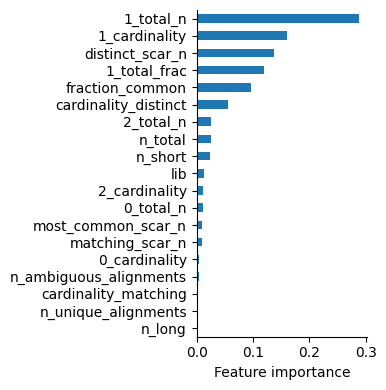

In [11]:
# Get feature importances


def plot_importances(clf):
    # Create a DataFrame for better visualization
    importances = clf.feature_importances_
    importance_series = pd.Series(importances,index = clf.feature_names_in_).sort_values()
    fig,ax = plt.subplots(figsize=(4,4))
    importance_series.plot.barh()

plot_importances(clf)
sns.despine()
plt.xlabel('Feature importance')
plt.tight_layout()
plt.savefig('./feature_importance_doublets.png')

In [12]:
import sklearn
probs = sklearn.model_selection.cross_val_predict(clf, X, y, method='predict_proba', n_jobs=-1)
pred = sklearn.model_selection.cross_val_predict(clf, X, y,  n_jobs=-1)

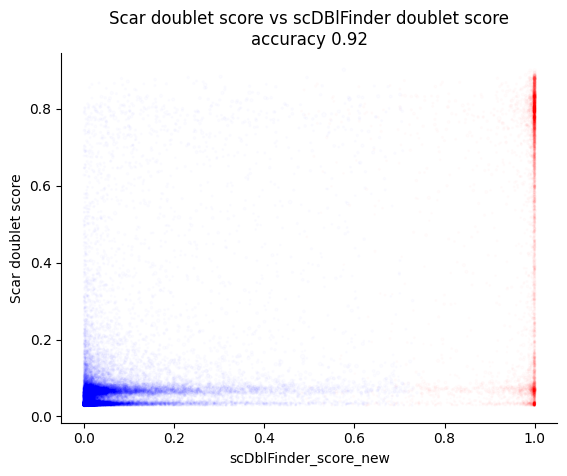

In [13]:
import matplotlib.pyplot as plt
import numpy as np


plt.scatter(merged_meta['scDblFinder_score_new'], 
            probs[:,0], alpha=0.01, c=( (merged_meta[tx_doublet_column]=='doublet')), s=0.1*np.sqrt(scar_meta_frame['most_common_scar_n'].loc[merged_meta.index])
           ,cmap='bwr'
           )

plt.xlabel('scDblFinder_score_new')
plt.ylabel('Scar doublet score')
sns.despine()
plt.title(f'Scar doublet score vs scDBlFinder doublet score\naccuracy {(pred==y).mean():.2f}')

plt.savefig('Scar doublet score vs scDBlFinder doublet score.png')
plt.savefig('Scar doublet score vs scDBlFinder doublet score.svg')

/tmp/ipykernel_3165325/3693862368.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(deviation,


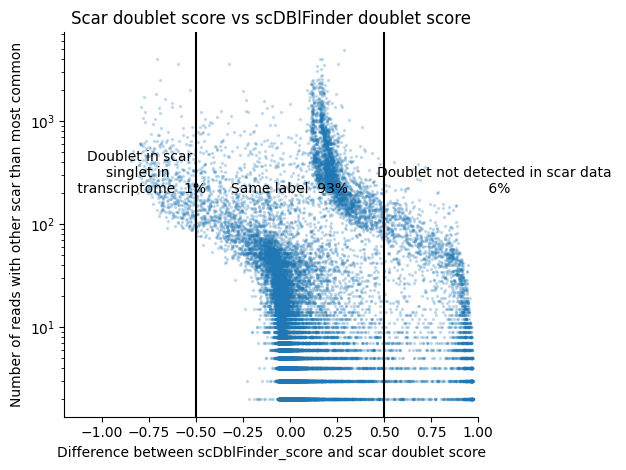

In [17]:


# Subset the cells which are not flagged as duplicate by the scars:
subset = (merged_meta['scDblFinder_score_new']>0.8) & ( probs[:,0]<0.2)

deviation = merged_meta['scDblFinder_score_new'] - probs[:,0]

y_axis_col = '1_total_n'
x_axis_col = 'scDblFinder_score_new'
plt.scatter(deviation, 
            merged_meta[y_axis_col], cmap='bwr', alpha=0.2,s=2
           )

plt.xlabel('Difference between scDblFinder_score and scar doublet score')
plt.ylabel('Number of reads with other scar than most common')
sns.despine()
plt.title(f'Scar doublet score vs scDBlFinder doublet score')
yh = 200
plt.text(0,yh,f'Same label  {(( (deviation<=0.5) & ((deviation>=-0.5))) .mean()*100):.0f}%',horizontalalignment='center')
plt.text(1.1,yh,f'Doublet not detected in scar data \n {((deviation>0.5).mean()*100):.0f}%',horizontalalignment='center')
plt.text(-0.8,yh,f'Doublet in scar\nsinglet in \n transcriptome  {((deviation<-0.5).mean()*100):.0f}%',horizontalalignment='center')
plt.axvline(0.5,c='k')
plt.axvline(-0.5,c='k')
plt.yscale('log')
plt.xlim(-1.2,1)
plt.tight_layout()
plt.savefig('scDblFinder_score and scar doublet score second_most_common_comparison.png')
plt.savefig('scDblFinder_score and scar doublet score second_most_common_comparison.svg')

most_common_scar_n


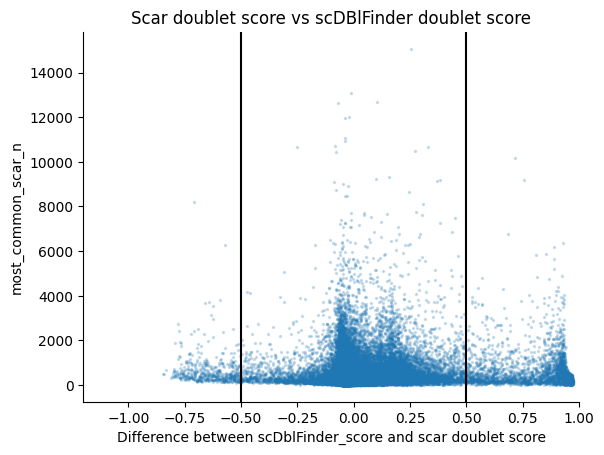

matching_scar_n


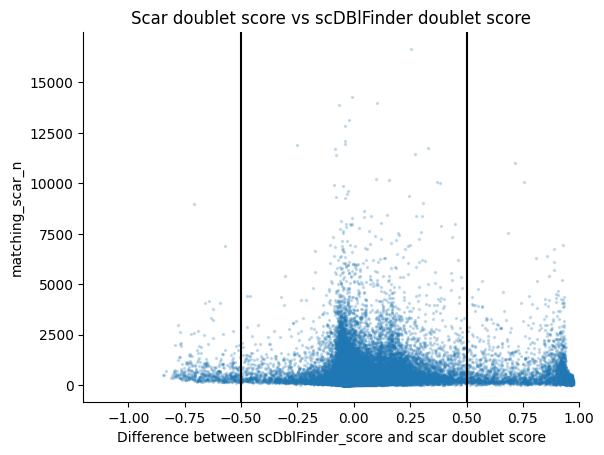

distinct_scar_n


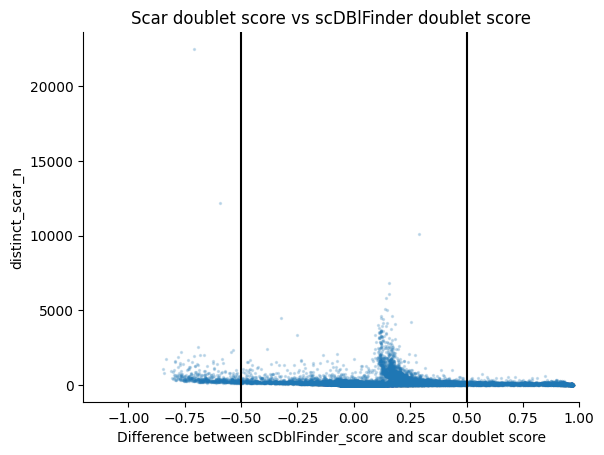

n_total


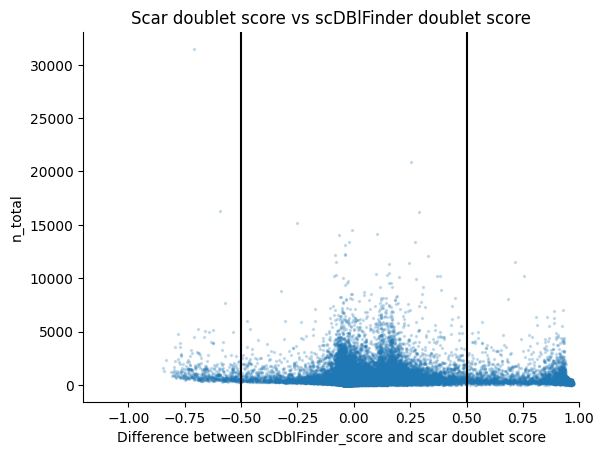

n_long


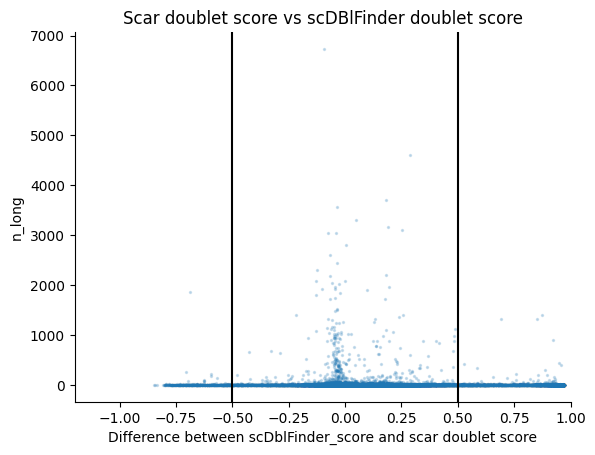

n_short


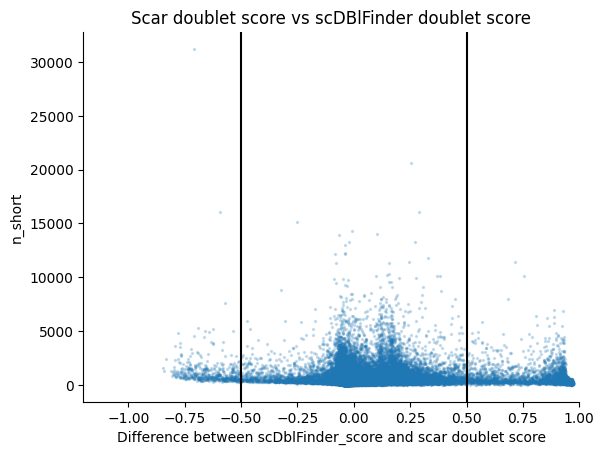

fraction_common


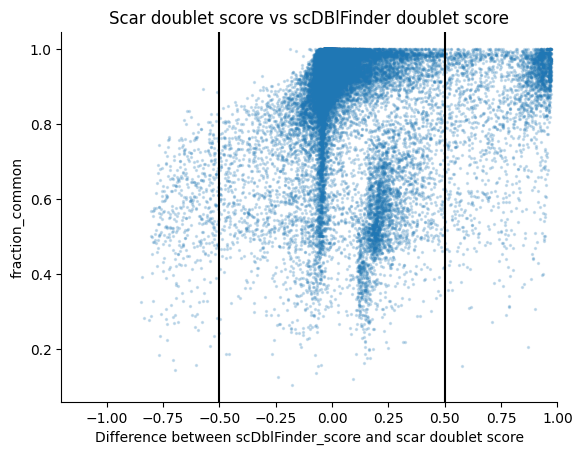

cardinality_distinct


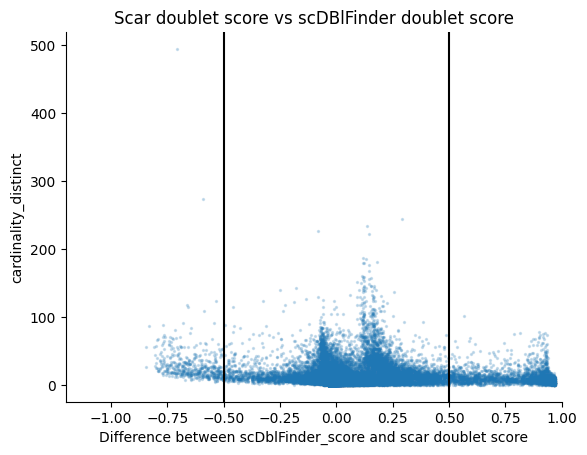

cardinality_matching


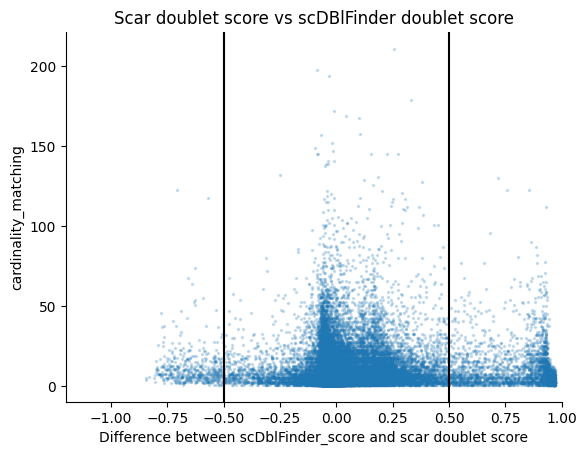

n_unique_alignments


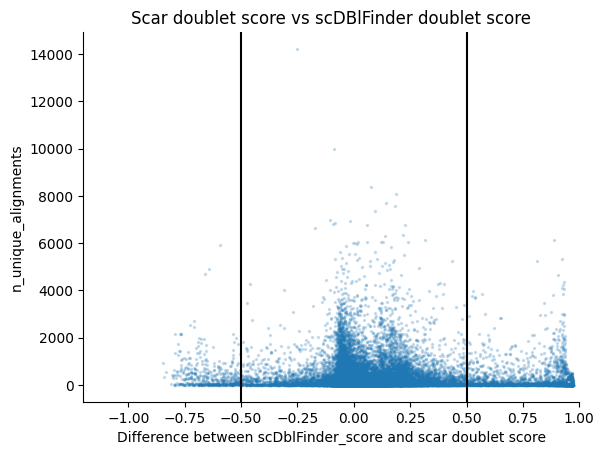

n_ambiguous_alignments


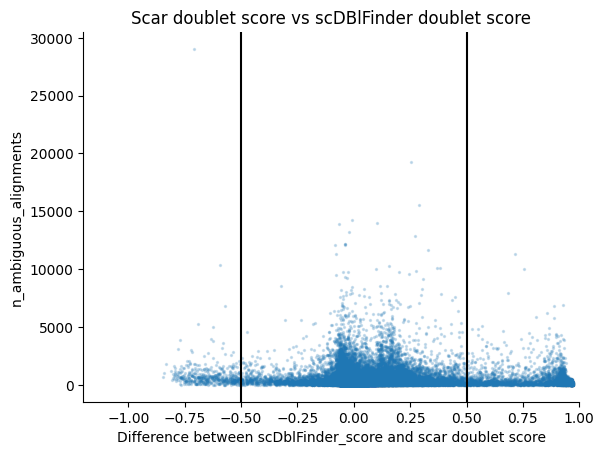

0_total_n


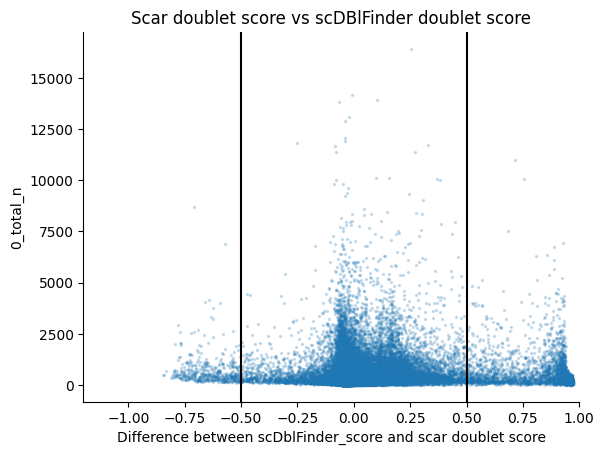

0_cardinality


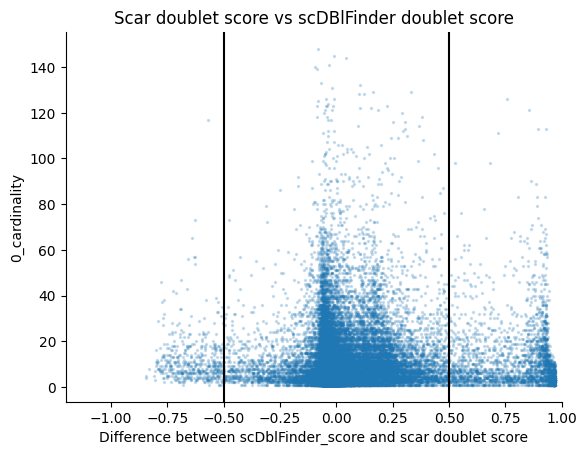

1_total_n


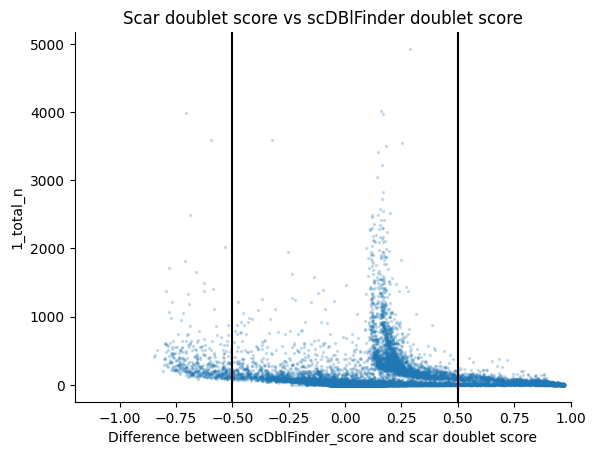

1_cardinality


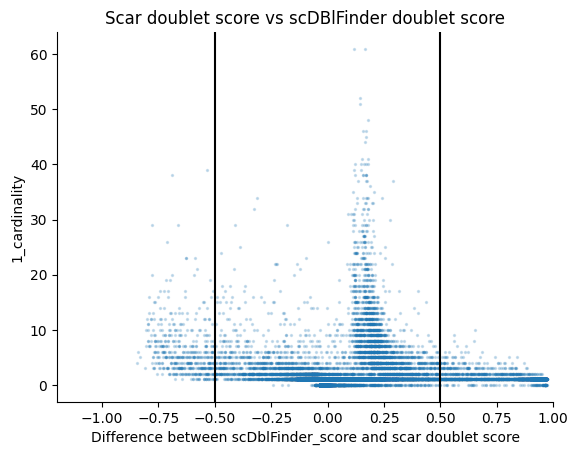

2_total_n


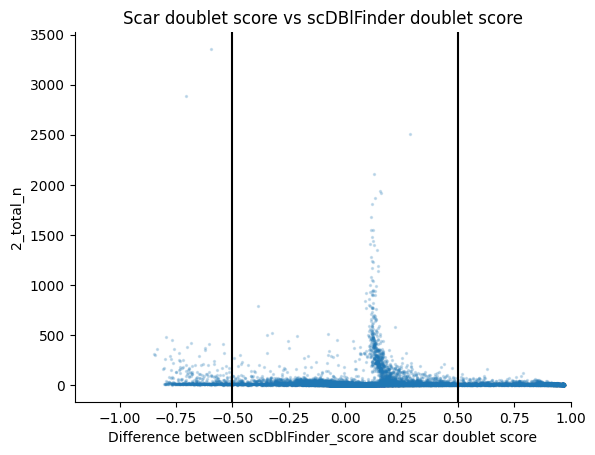

2_cardinality


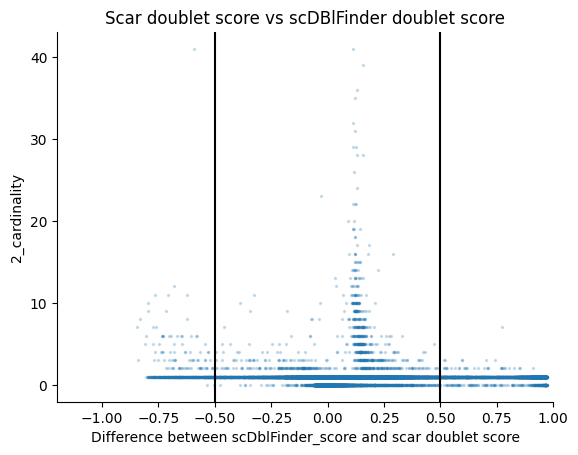

1_total_frac


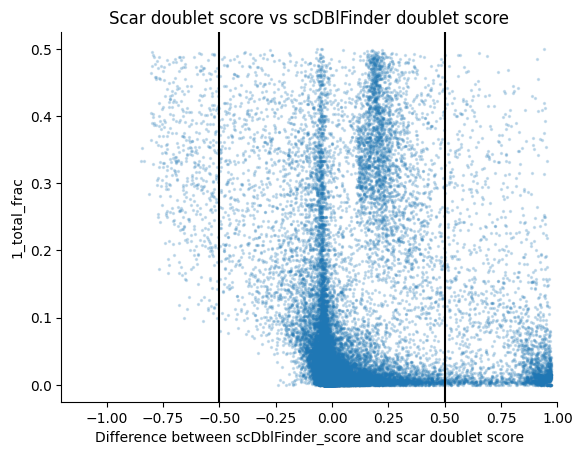

nCount_RNA


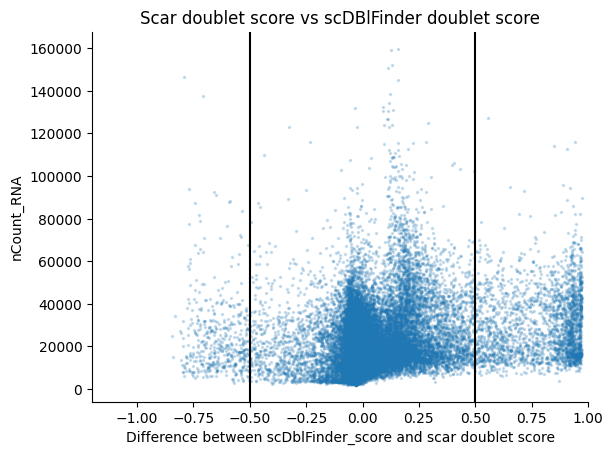

nFeature_RNA


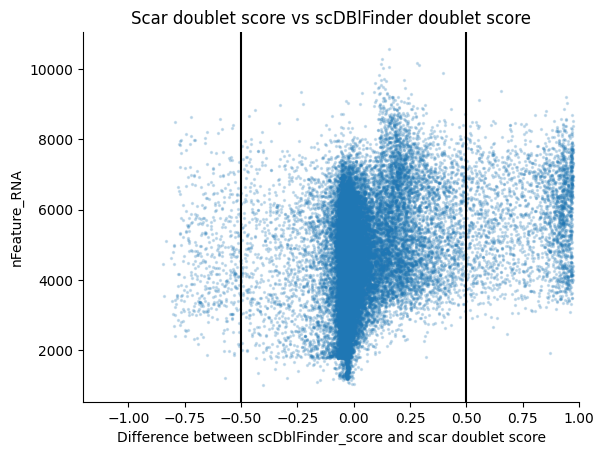

log1p_nCount_RNA


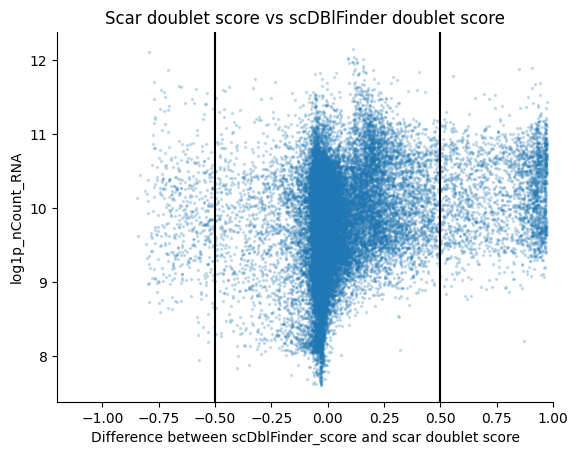

log1p_nFeature_RNA


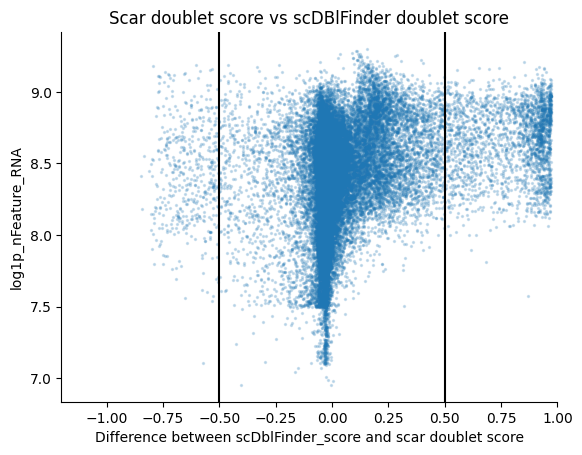

percent.mt


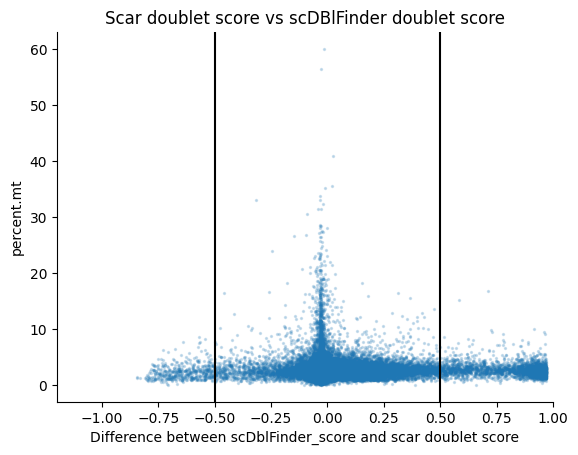

percent.ribo


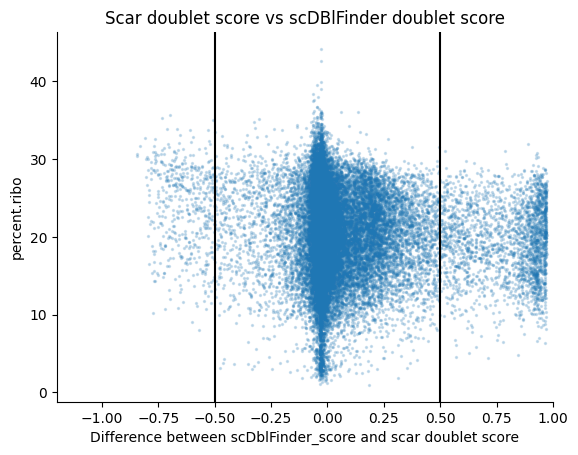

mad5_nFeature_RNA


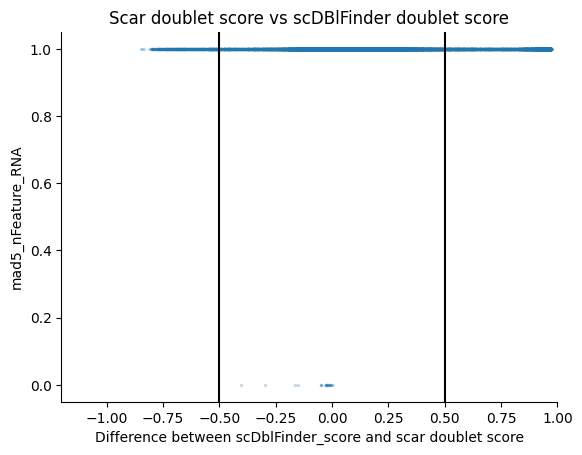

mad3_nFeature_RNA


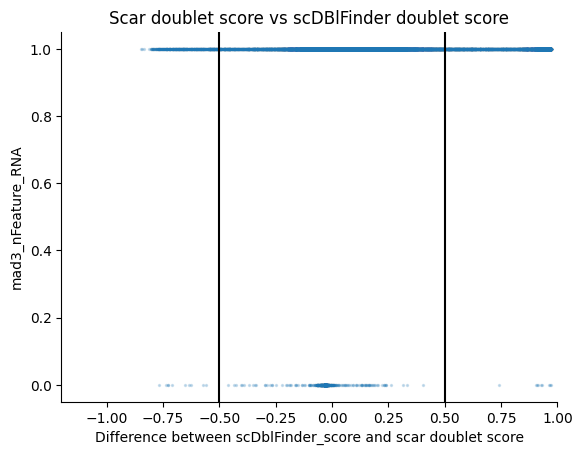

mad5_nCount_RNA


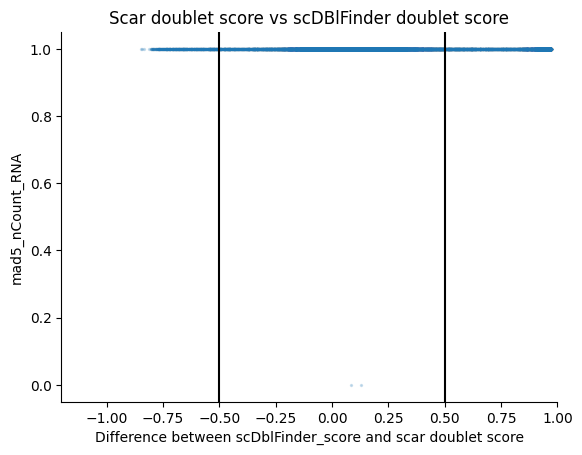

mad3_nCount_RNA


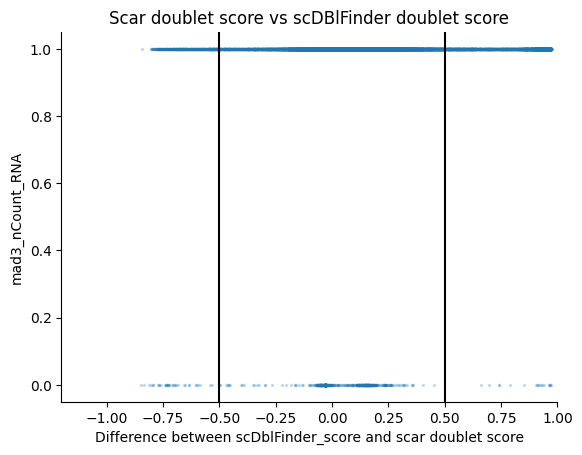

mad5_percent_mt


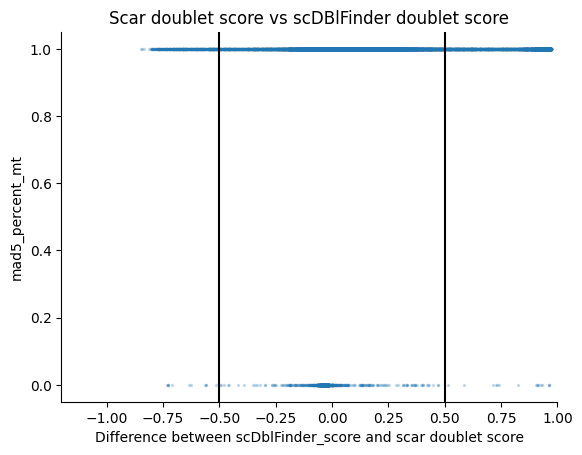

mad3_percent_mt


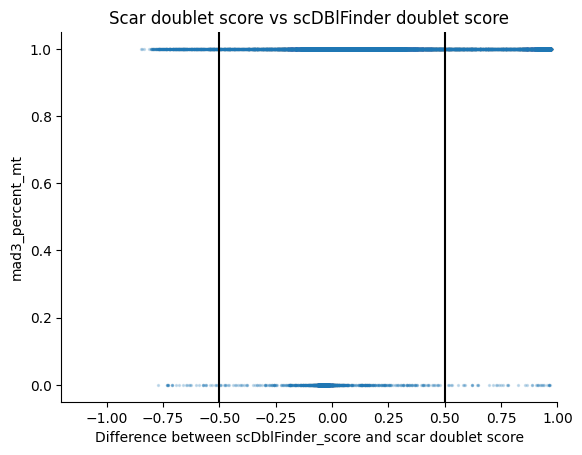

mad555


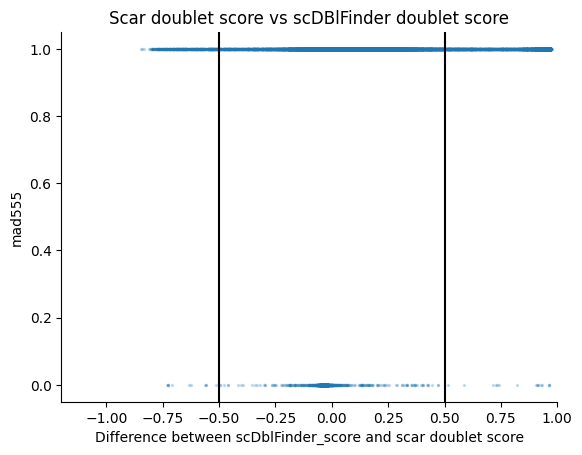

mad333


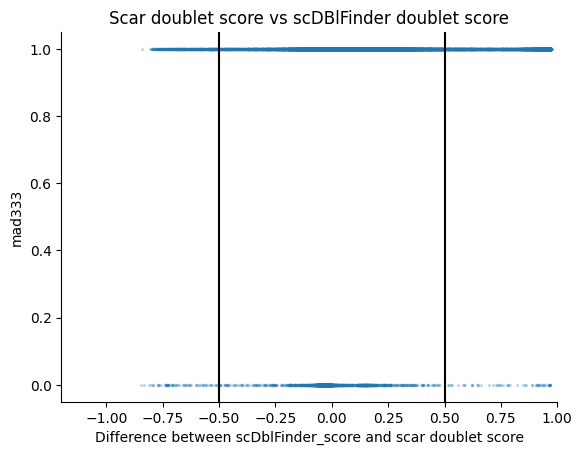

mad553


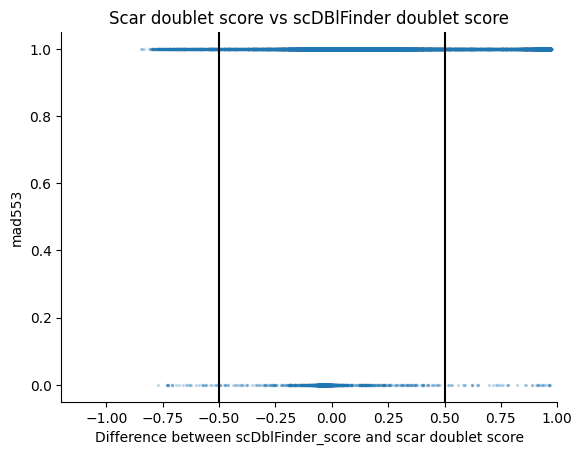

RNA_snn_res.1.2


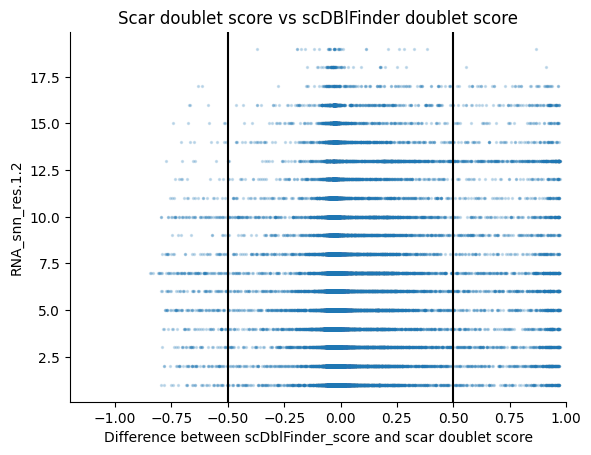

seurat_clusters


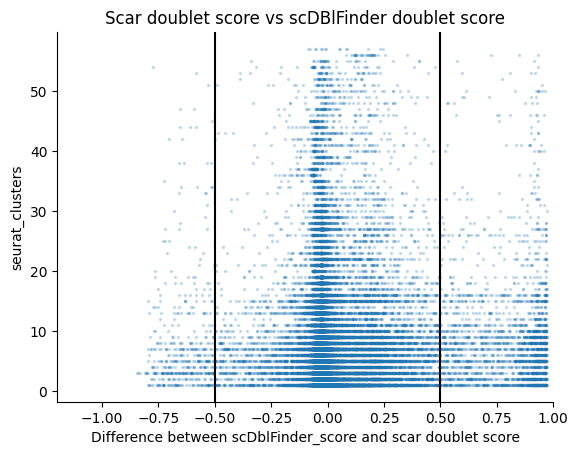

soup_group


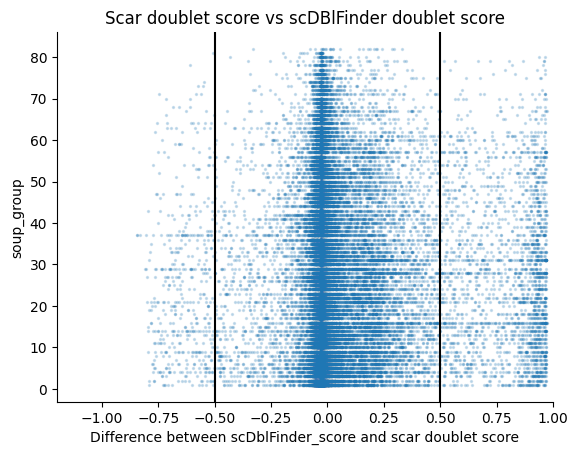

scDblFinder_score


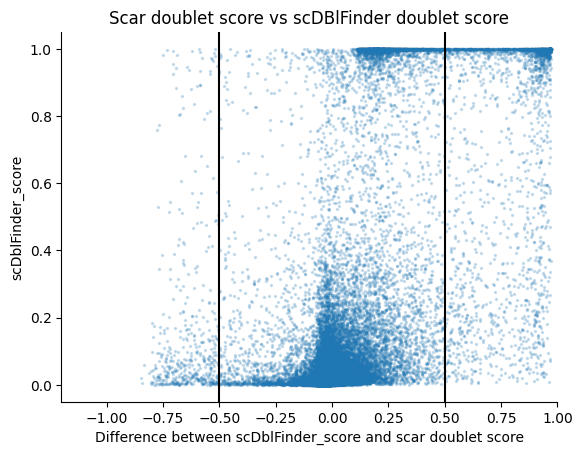

S.Score


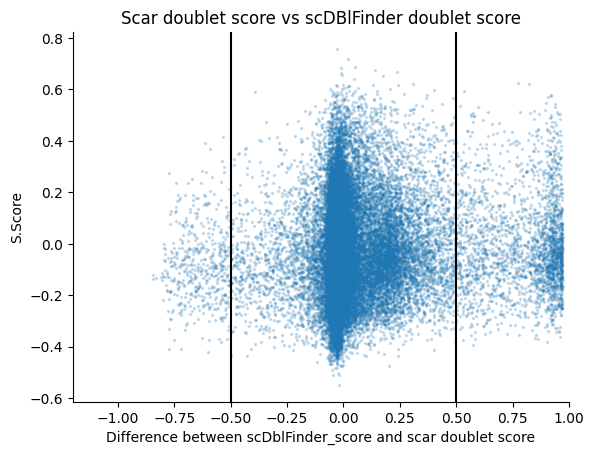

G2M.Score


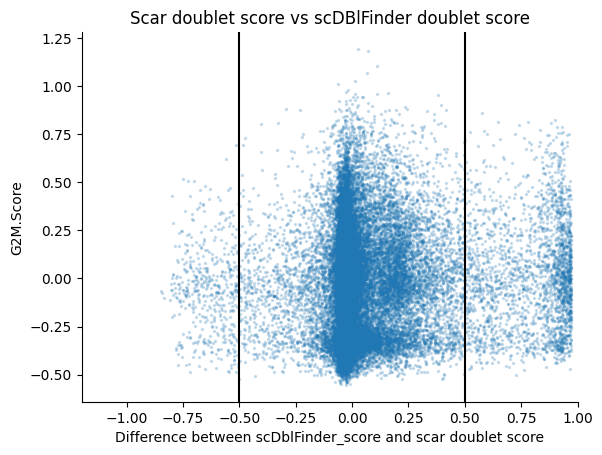

RNA_snn_res.2


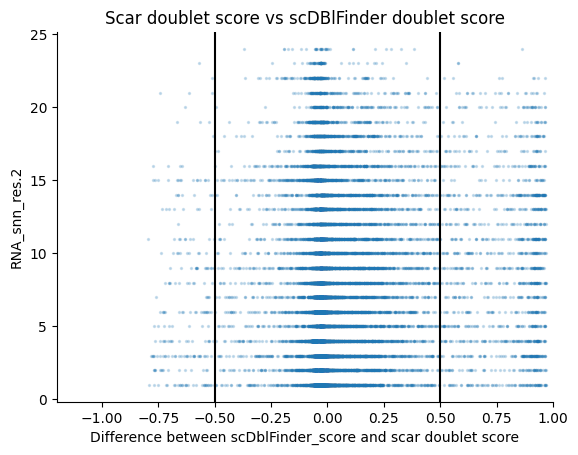

scDblFinder_score_new


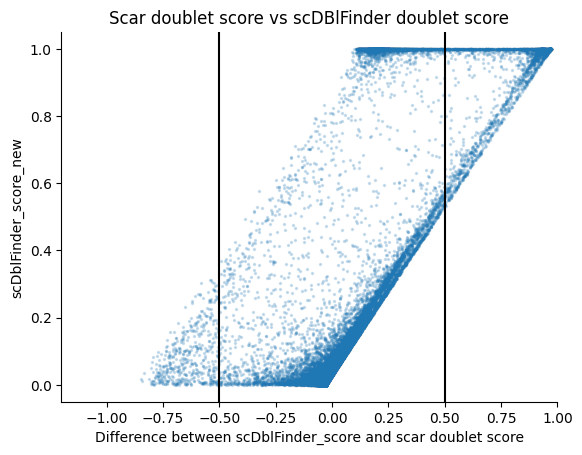

RNA_snn_res.10


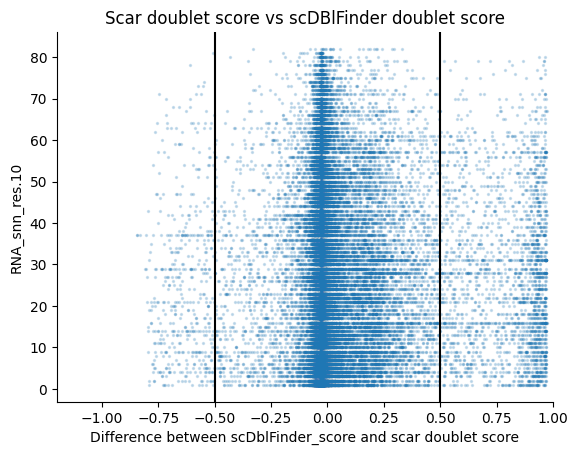

scDblFinder_score_lv2


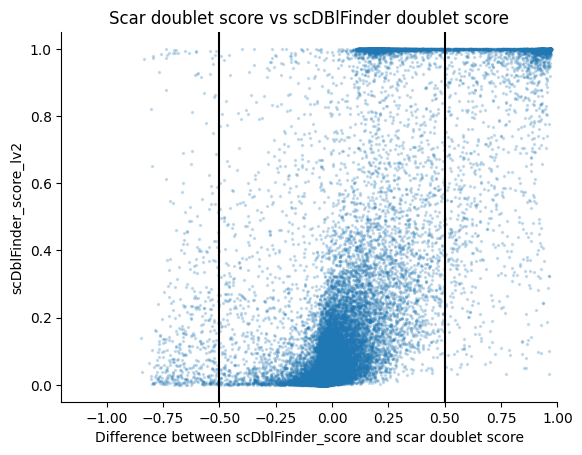

RNA_snn_res.6


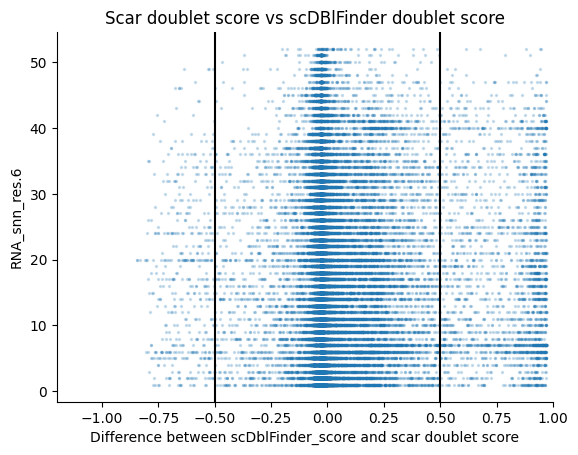

nCount_SCT


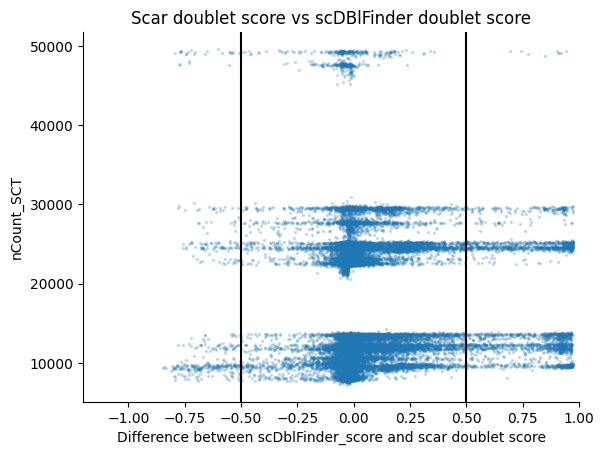

nFeature_SCT


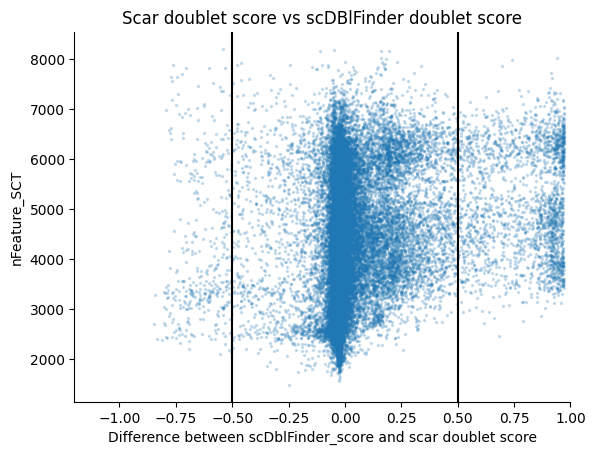

unintegrated_clusters


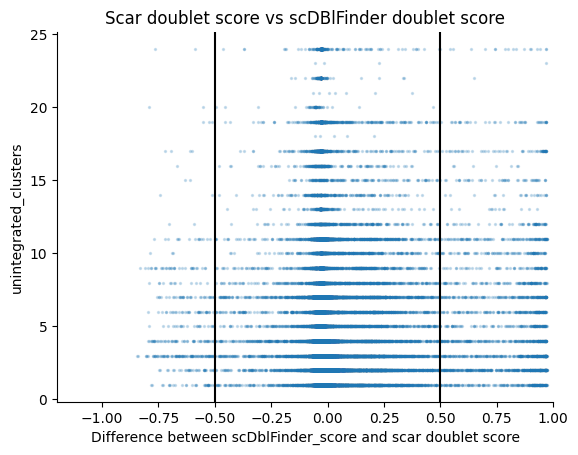

clustering_sct.0.25


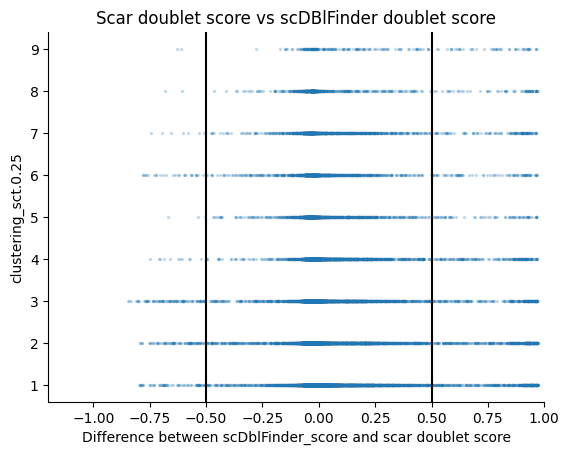

clustering_sct.0.5


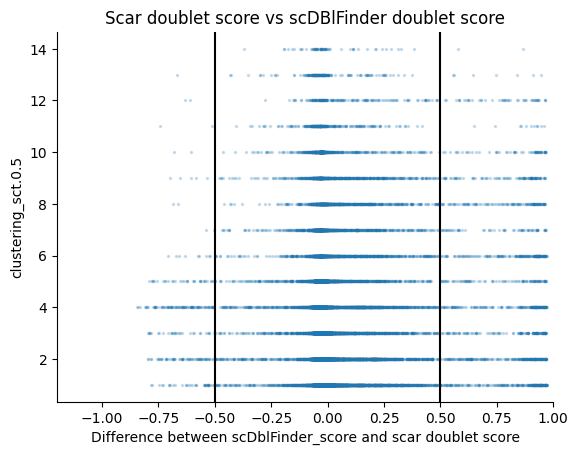

clustering_sct.0.75


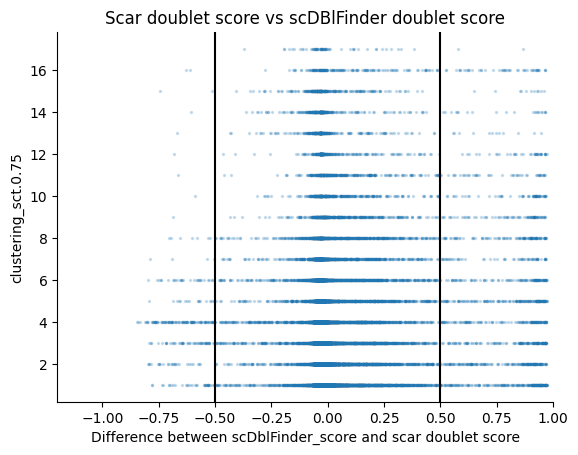

clustering_sct.1


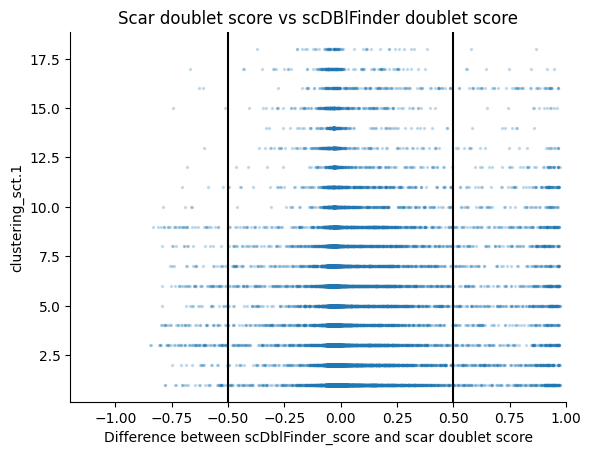

clustering_sct.1.25


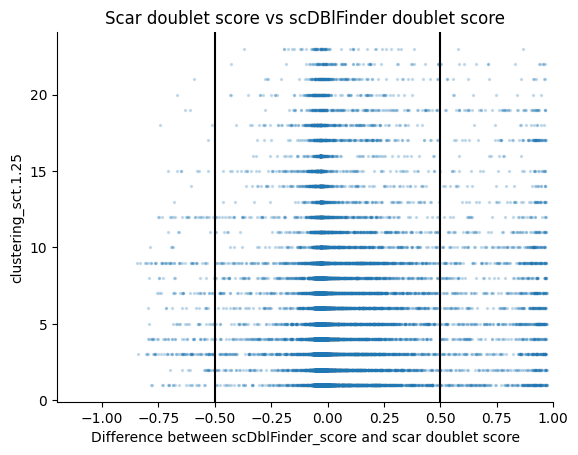

clustering_sct.1.5


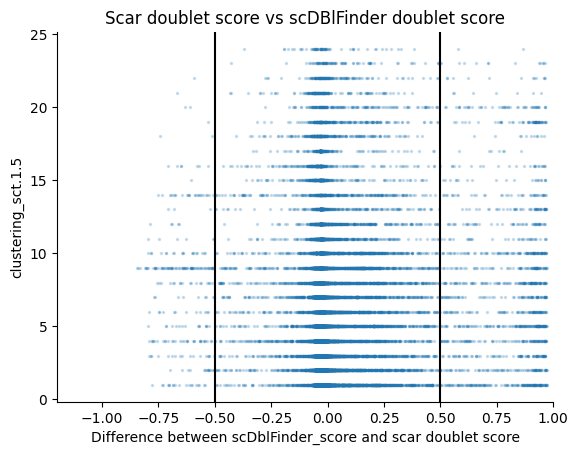

clustering_sct.1.75


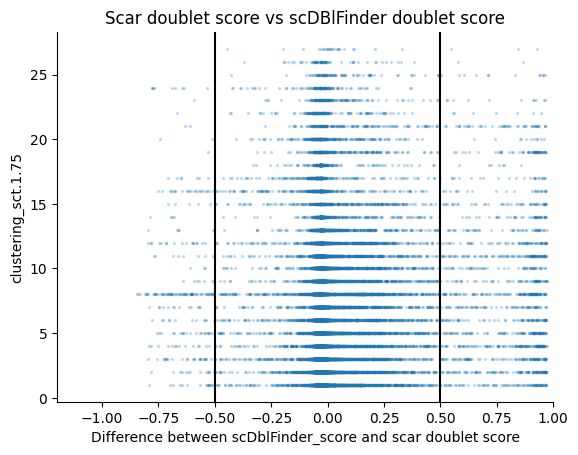

clustering_sct.2


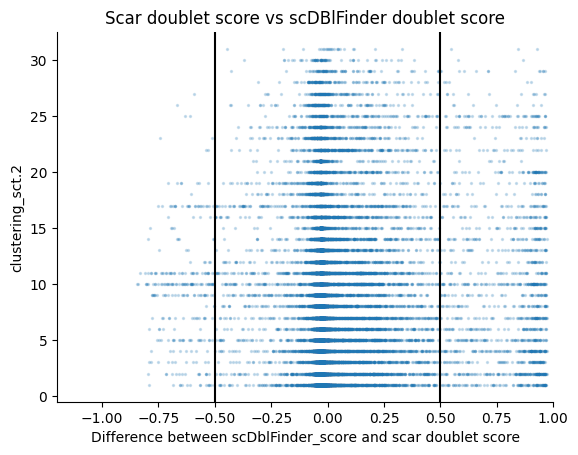

clustering_sct.0.3


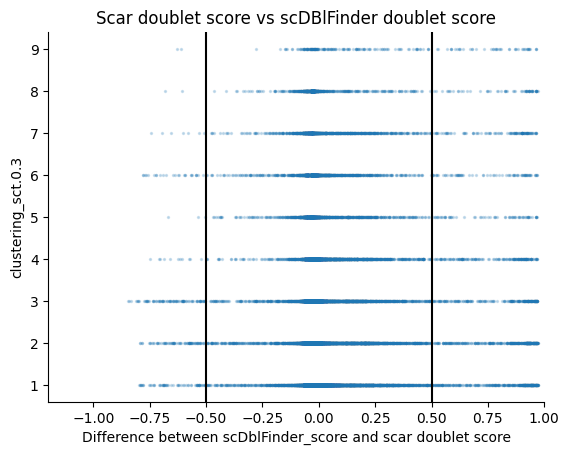

clustering_sct.0.4


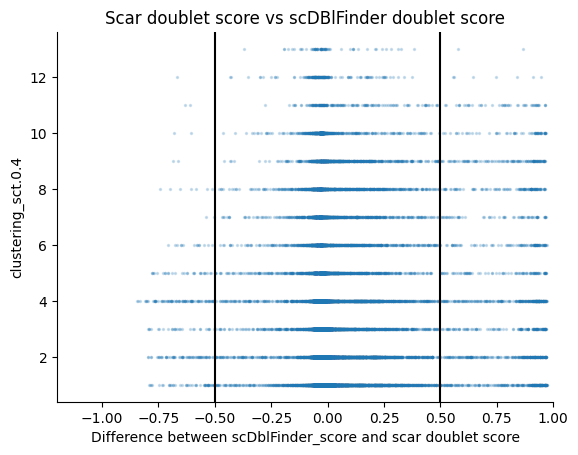

clustering_sct.0.6


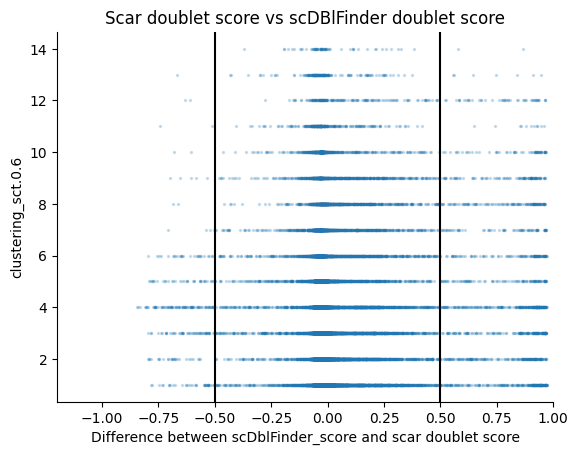

clustering_sct.0.7


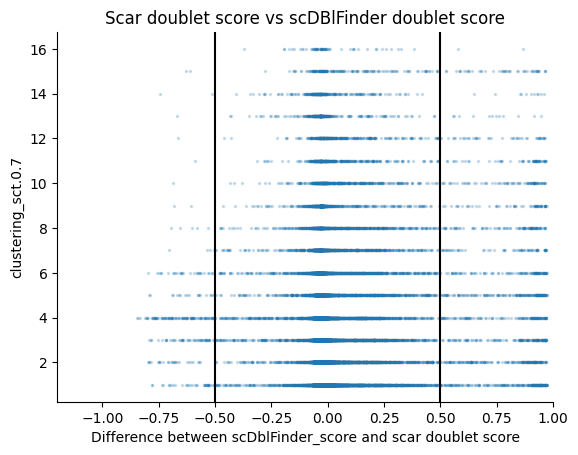

clustering_sct.0.8


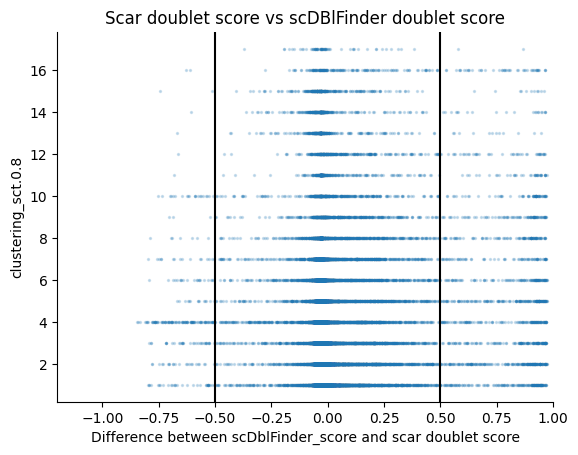

clustering_sct.0.9


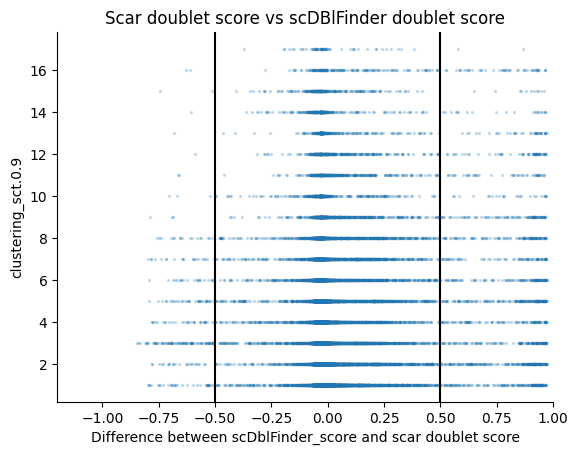

clustering_sct.1.1


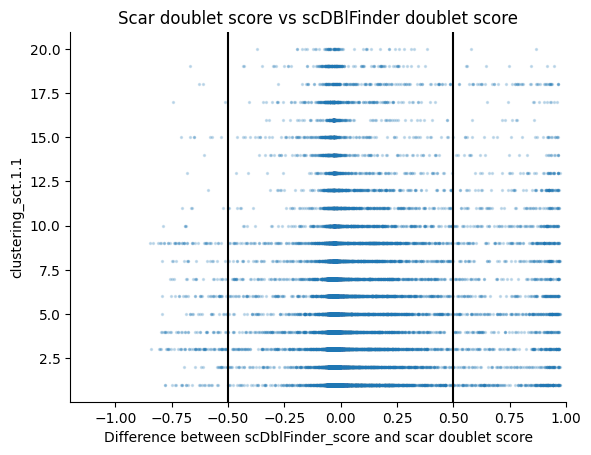

clustering_sct.1.2


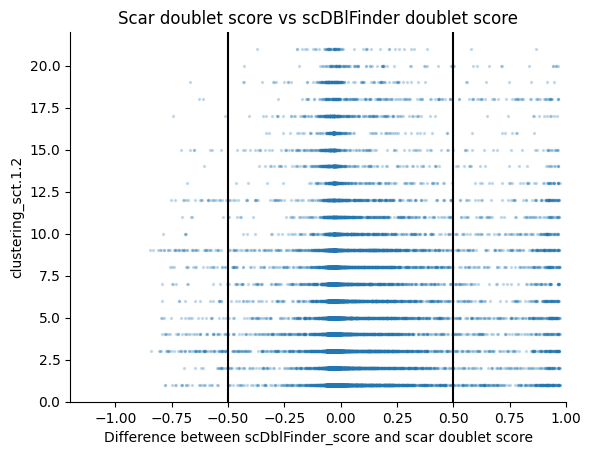

clustering_sct.0.55


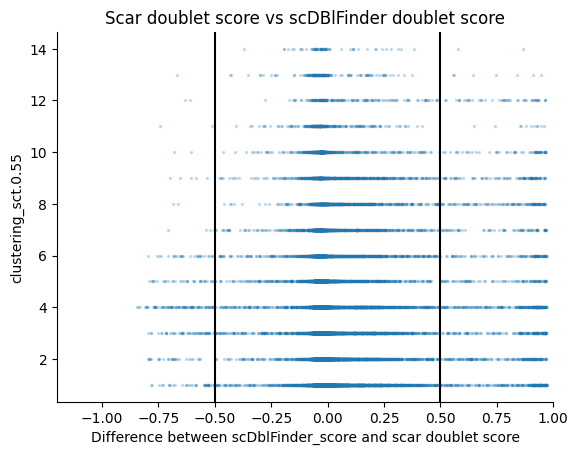

clustering_sct.0.95


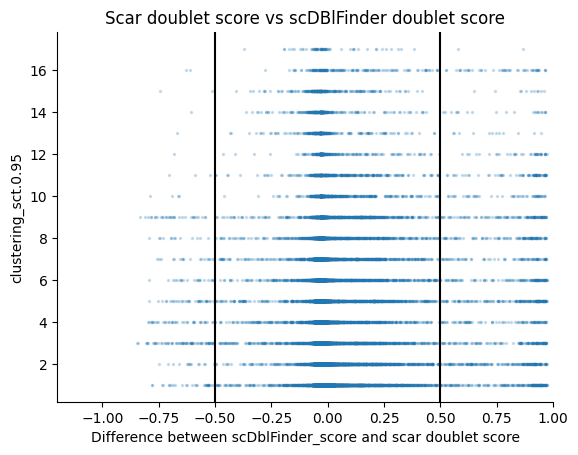

clustering_sct.0.65


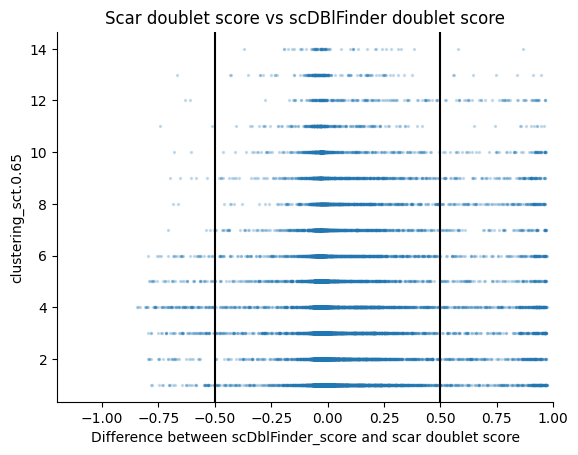

clustering_sct.0.35


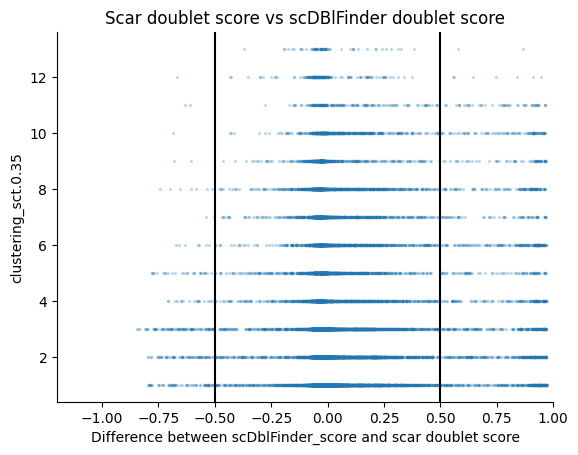

clustering_sct.0.45


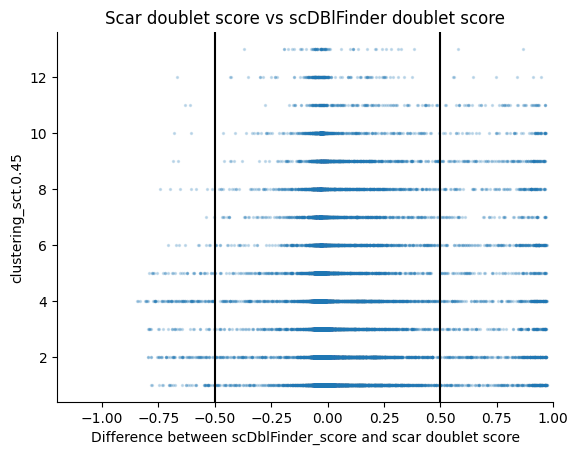

clustering_sct.0.85


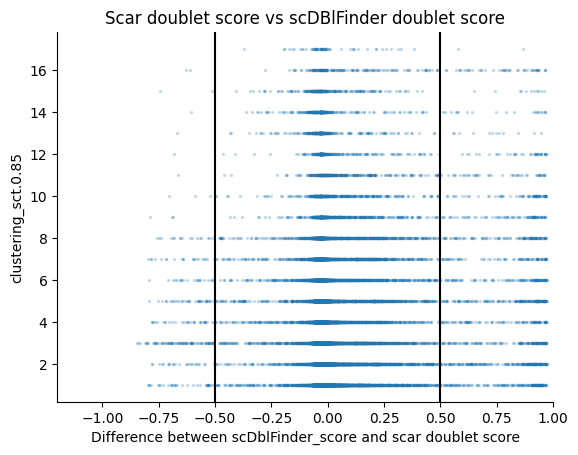

clusters_a


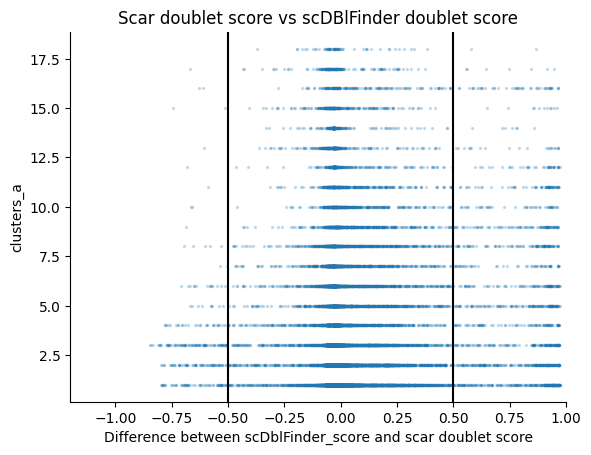

harmony_clusters


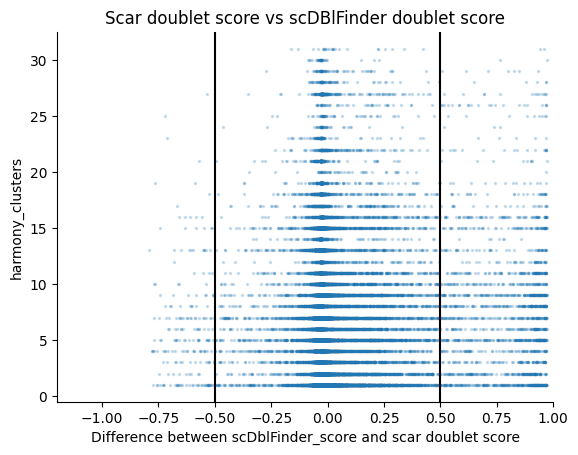

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Subset the cells which are not flagged as duplicate by the scars:

for col in merged_meta.loc[X.index][merged_meta.dtypes[merged_meta.dtypes != np.dtype('O')].index].columns:
    print(col)
    subset = (merged_meta['scDblFinder_score_new']>0.8) & ( probs[:,0]<0.2)
    
    deviation = merged_meta['scDblFinder_score_new'] - probs[:,0]
    
    y_axis_col = col #'percent.ribo' #'nFeature_RNA'
    x_axis_col = 'scDblFinder_score_new'
    fig, ax = plt.subplots()
    plt.scatter(deviation, 
                merged_meta[y_axis_col], alpha=0.2,s=2 # cmap='bwr',
               )
    
    plt.xlabel('Difference between scDblFinder_score and scar doublet score')
    plt.ylabel(y_axis_col)
    sns.despine()
    plt.title(f'Scar doublet score vs scDBlFinder doublet score')
    yh = 1
    if False:
        plt.text(0,yh,f'Same label  {(( (deviation<=0.5) & ((deviation>=-0.5))) .mean()*100):.0f}%',horizontalalignment='center')
        plt.text(1.1,yh,f'Doublet not detected in scar data \n {((deviation>0.5).mean()*100):.0f}%',horizontalalignment='center')
        plt.text(-0.8,yh,f'Doublet in scar\nsinglet in \n transcriptome  {((deviation<-0.5).mean()*100):.0f}%',horizontalalignment='center')
    plt.axvline(0.5,c='k')
    plt.axvline(-0.5,c='k')
    #plt.yscale('log')
    plt.xlim(-1.2,1)
    plt.show()
    plt.close()

In [19]:
## Remove common scars
singlets = scar_meta_frame.loc[X.index][y=='singlet']
scar_obs = singlets['most_common_scar_desc'].value_counts(sort=True)

In [20]:
# Group by library, then calculate entropy
from scipy.stats import entropy
select_scars = scar_obs.index
scars_per_lib= {}
for lib, data in singlets.groupby( [idx.split('_')[-1] for idx in singlets.index] ):
    vc = data['most_common_scar_desc'].value_counts()
    scars_per_lib[lib] = vc.loc[[x for x in select_scars if x in vc.index]]

scars_per_lib = pd.DataFrame(scars_per_lib).fillna(0)

In [21]:
singlets.to_csv('../data/singlets.csv')

In [22]:
# Same but now for all cells, export the probability of being a doublet

In [23]:
all_cell_meta_for_export = scar_meta_frame.loc[X.index]

all_cell_meta_for_export['scar_posterior_doublet'] = probs[:,0]
all_cell_meta_for_export.to_csv('../data/scar_data_with_doublet_prob.csv')